In [2]:
import os
import json
import yaml
import torch
import random
import detectron2

import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

from detectron2 import model_zoo
from detectron2.config import get_cfg
from detectron2.structures import BoxMode
from detectron2.engine import DefaultTrainer
from detectron2.engine import DefaultPredictor
from detectron2.utils.visualizer import ColorMode
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

In [3]:
# Verify GPU information
print (torch.cuda.is_available(), torch.cuda.device_count(), torch.cuda.current_device(), torch.cuda.device(0)
       , torch.cuda.get_device_name(0))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

# Additional info when using CUDA
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

True 1 0 <torch.cuda.device object at 0x1555505edc70> NVIDIA A30
Using device: cuda

NVIDIA A30
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [4]:
# Indicate to D2 how to read dataset if not in coco format:

def get_dataset_dicts(img_dir):
    """Function that tells detectron2 know how to obtain a custom datasets by specifying it similarly to COCO’s annotations: see https://detectron2.readthedocs.io/en/latest/tutorials/datasets.html 

    Args:
        img_dir (str): path to the directory containing the images and annotations .json file 

    Returns:
        list: list of dictionaries containing the information of the dataset
    """
    json_file = os.path.join(img_dir, "via_region_data.json")
    with open(json_file) as f:
        imgs_anns = json.load(f)
    
    dataset_dicts = []
    for idx, annots in enumerate(imgs_anns.values()):
        record = {}
        
        filename = os.path.join(img_dir, annots["filename"])
        height, width = cv.imread(filename).shape[:2]
        
        #Info on the tile .png file
        record["file_name"] = filename
        record["image_id"] = idx
        record["height"] = height
        record["width"] = width
        
        #info on annotation
        annotations = annots["regions"]
        objs = []
        for _, anno in annotations.items():
            assert not anno["region_attributes"]
            anno = anno["shape_attributes"]
            px = anno["all_points_x"]
            py = anno["all_points_y"]
            poly = [(x + 0.5, y + 0.5) for x, y in zip(px, py)]
            poly = [p for x in poly for p in x]

            obj = {
                "bbox": [np.min(px),
                         np.min(py),
                         np.max(px),
                         np.max(py)
                        ],
                #XYXY_ABS: https://detectron2.readthedocs.io/en/latest/_modules/detectron2/structures/boxes.html
                "bbox_mode": BoxMode.XYXY_ABS,
                "segmentation": [poly],
                "category_id": anno["category"]
            }
            objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts

classes = ["asset"]
colors = [(249, 180, 45)]

#Register dataset and metadata
for d in ["train", "val"]:
    DatasetCatalog.register(d, lambda d=d: get_dataset_dicts(os.path.join("../NSO", d)))
    # Key-value mappingto interpret what’s in the dataset: names of classes, colors of classes
    MetadataCatalog.get(d).thing_classes = classes
    MetadataCatalog.get(d).thing_colors = colors

../NSO/train/1_6902_23214.png


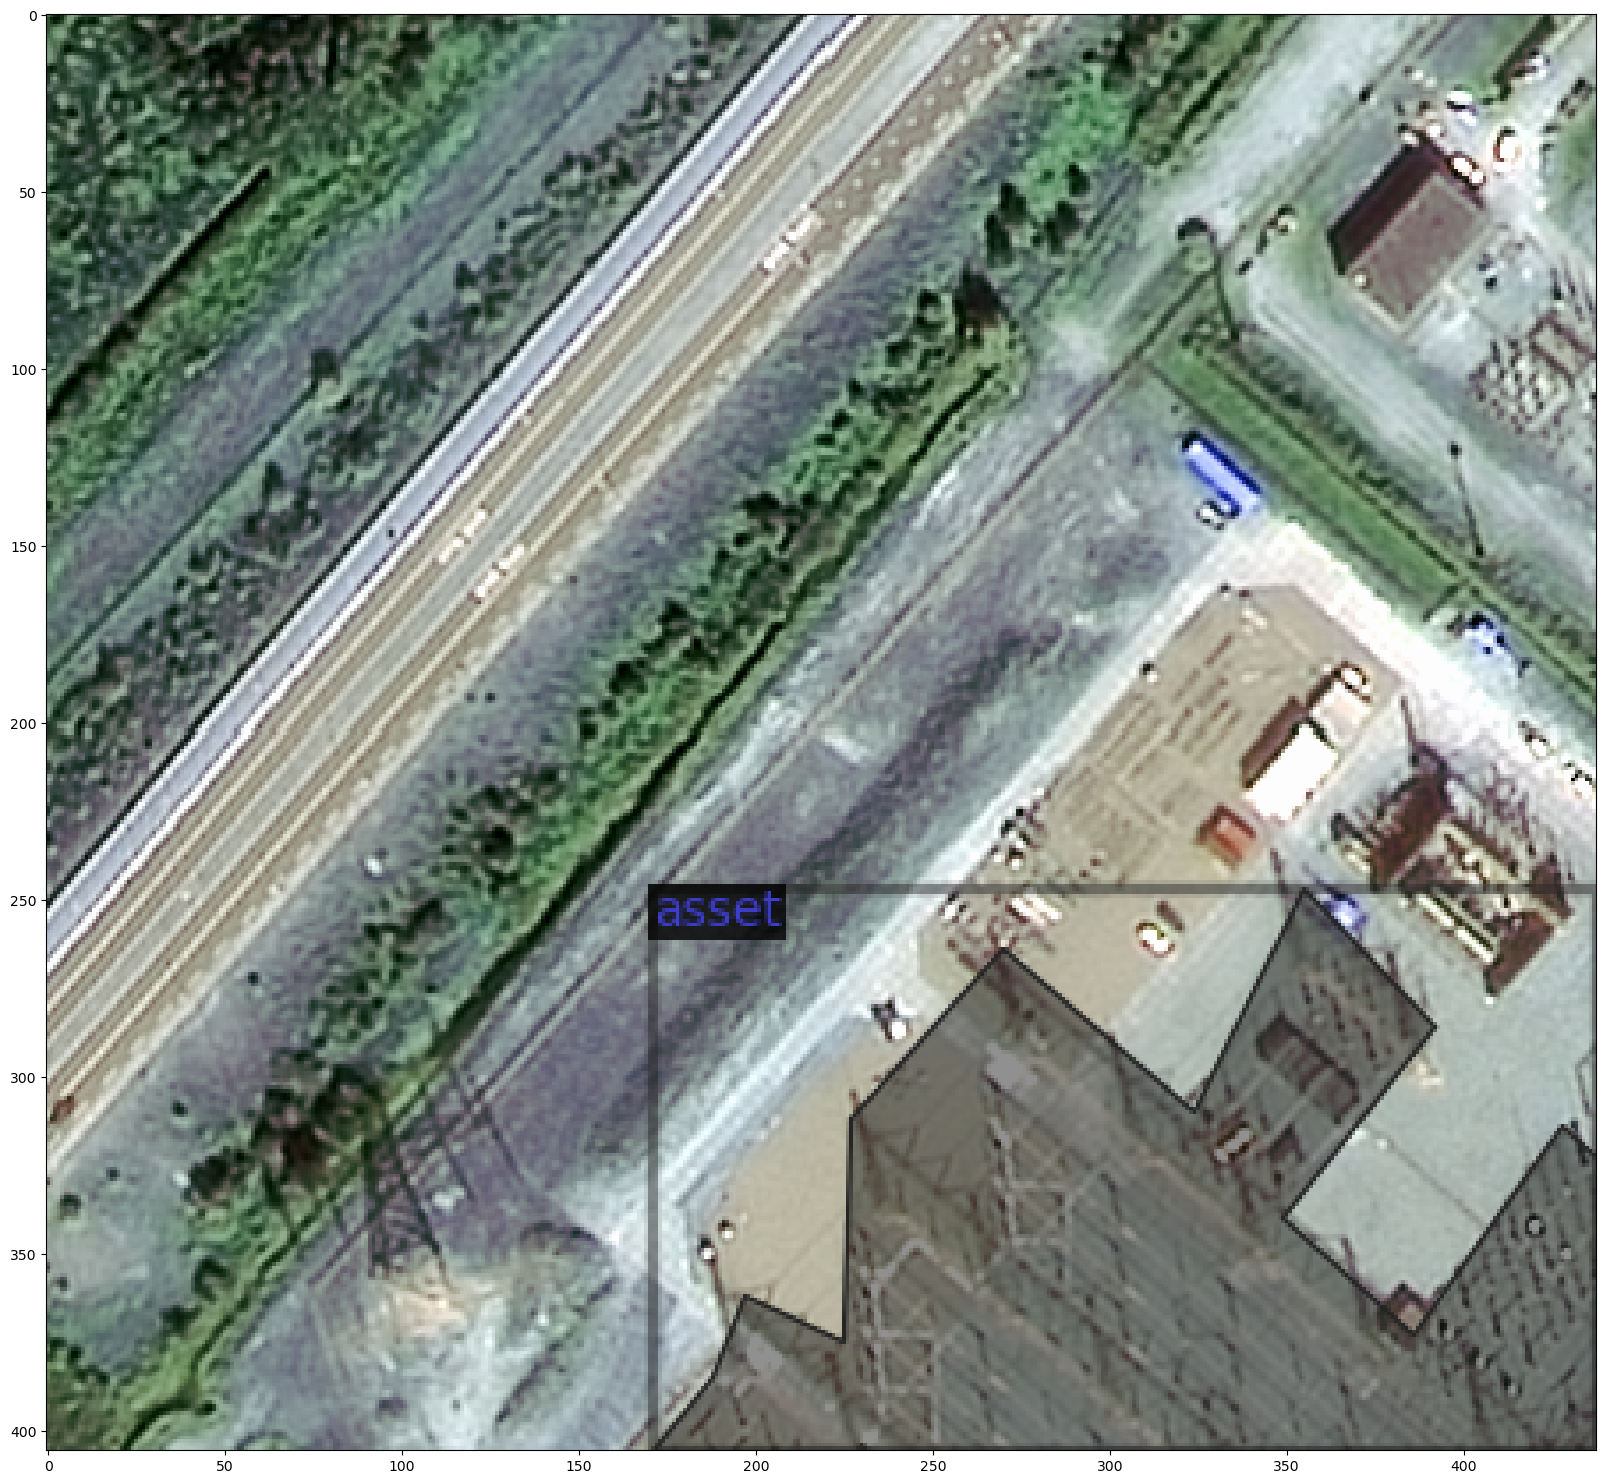

In [17]:
# Visualise annotations of trainning dataset
# Urgent! Prob with several annot on the same tile...

metadata = MetadataCatalog.get("train")
dataset_dicts = get_dataset_dicts("../NSO/train")

for d in random.sample(dataset_dicts, 1):
    img = cv.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=metadata, scale=1, instance_mode=ColorMode.IMAGE)
    out = visualizer.draw_dataset_dict(d)
    print(d["file_name"])
    plt.figure(figsize=(20, 20))
    plt.imshow(out.get_image()[:, :, ::-1]) #BGR to RGB
    plt.show()

In [23]:
# Setting up model configugation for training

# initializes an empty config
cfg = get_cfg()

# add custom component to configuration
# load values from API: https://github.com/facebookresearch/detectron2/blob/main/MODEL_ZOO.md
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_1x.yaml"))
cfg.DATASETS.TRAIN = ("train",)
cfg.DATASETS.TEST = () # should not be set for training: https://github.com/facebookresearch/detectron2/issues/951
# initiate weights from model zoo
# check points (.pth) = model's parameters and optimizer state to resume training or evalate performance
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_1x.yaml")
# set learning rate
cfg.SOLVER.BASE_LR = 0.005
# Dataloader provides data to the model
# Load data to GPU: the more data you put into the GPU memory, the less memory is available for the model (4 in Spacenet)
# https://discuss.pytorch.org/t/guidelines-for-assigning-num-workers-to-dataloader/813/33?page=2
# https://stackoverflow.com/questions/53998282/how-does-the-number-of-workers-parameter-in-pytorch-dataloader-actually-work
cfg.DATALOADER.NUM_WORKERS = 2
# real batch size:  number of training examples utilized in one iteration.
cfg.SOLVER.IMS_PER_BATCH = 16
# parameter  used to sample a subset of proposals coming out of RPN to calculate cls and reg loss during training
# "RoIHead batch size". 128 is faster, and good enough for this toy dataset (default: 512). Spacenet uses 16 for 4 GPUs 
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 4
# Number of class = 1 (1 asset Type)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1

# config not included SPACENET
# adjust up if val mAP is still rising, adjust down if overfit/ 300 iterations seems good for toy dataset
cfg.SOLVER.MAX_ITER = 100    
# [] => do not decay learning rate 
cfg.SOLVER.STEPS = []
#cfg.SOLVER.WARMUP_ITERS = 1000
#cfg.SOLVER.GAMMA = 0.05
#number of itteration after wich the validation set is used for evaluation
cfg.TEST.EVAL_PERIOD = 50 


# Directory for (logs, configs, metrics, and model checkpoints)
cfg.OUTPUT_DIR = "../NSO/output"
# print configs 
print(cfg.dump())

# Save your configurations for multi-GPU use
with open("../NSO/NSOD2cfg_Abcoude.yaml", "w") as file:
    yaml.dump(cfg, file)

CUDNN_BENCHMARK: false
DATALOADER:
  ASPECT_RATIO_GROUPING: true
  FILTER_EMPTY_ANNOTATIONS: true
  NUM_WORKERS: 2
  REPEAT_THRESHOLD: 0.0
  SAMPLER_TRAIN: TrainingSampler
DATASETS:
  PRECOMPUTED_PROPOSAL_TOPK_TEST: 1000
  PRECOMPUTED_PROPOSAL_TOPK_TRAIN: 2000
  PROPOSAL_FILES_TEST: []
  PROPOSAL_FILES_TRAIN: []
  TEST: []
  TRAIN:
  - train
GLOBAL:
  HACK: 1.0
INPUT:
  CROP:
    ENABLED: false
    SIZE:
    - 0.9
    - 0.9
    TYPE: relative_range
  FORMAT: BGR
  MASK_FORMAT: polygon
  MAX_SIZE_TEST: 1333
  MAX_SIZE_TRAIN: 1333
  MIN_SIZE_TEST: 800
  MIN_SIZE_TRAIN:
  - 640
  - 672
  - 704
  - 736
  - 768
  - 800
  MIN_SIZE_TRAIN_SAMPLING: choice
  RANDOM_FLIP: horizontal
MODEL:
  ANCHOR_GENERATOR:
    ANGLES:
    - - -90
      - 0
      - 90
    ASPECT_RATIOS:
    - - 0.5
      - 1.0
      - 2.0
    NAME: DefaultAnchorGenerator
    OFFSET: 0.0
    SIZES:
    - - 32
    - - 64
    - - 128
    - - 256
    - - 512
  BACKBONE:
    FREEZE_AT: 2
    NAME: build_resnet_fpn_backbone
  DEVICE

In [ ]:
%load_ext tensorboard
%tensorboard --logdir output

In [24]:
# Single GPU Training

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
# DefaultTrainer" which contains pre-defined default logic for standard training workflow.
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()
#Expect skip loading parameter because: The warning message is expected. Because your dataset has different number of classes from the pre-trained model, a few pre-trained weights have to be skipped.

[03/08 19:10:15 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

[03/08 19:10:15 d2.data.build]: Removed 0 images with no usable annotations. 6 images left.
[03/08 19:10:15 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[03/08 19:10:15 d2.data.build]: Using training sampler TrainingSampler
[03/08 19:10:15 d2.data.common]: Serializing 6 elements to byte tensors and concatenating them all ...
[03/08 19:10:15 d2.data.common]: Serialized dataset takes 0.00 MiB


Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (2, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (2,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (1, 256, 1, 1) in

[03/08 19:10:15 d2.engine.train_loop]: Starting training from iteration 0
[03/08 19:10:37 d2.utils.events]:  eta: 0:01:07  iter: 19  total_loss: 1.879  loss_cls: 0.4876  loss_box_reg: 0.6871  loss_mask: 0.6682  loss_rpn_cls: 0.05275  loss_rpn_loc: 0.00917  time: 1.0492  data_time: 0.4279  lr: 0.00095405  max_mem: 10845M
[03/08 19:10:58 d2.utils.events]:  eta: 0:00:50  iter: 39  total_loss: 1.341  loss_cls: 0.1463  loss_box_reg: 0.7132  loss_mask: 0.4034  loss_rpn_cls: 0.00913  loss_rpn_loc: 0.00807  time: 1.0603  data_time: 0.4290  lr: 0.0019531  max_mem: 10845M
[03/08 19:11:19 d2.utils.events]:  eta: 0:00:33  iter: 59  total_loss: 0.6448  loss_cls: 0.05474  loss_box_reg: 0.3627  loss_mask: 0.2291  loss_rpn_cls: 0.002824  loss_rpn_loc: 0.005575  time: 1.0608  data_time: 0.4223  lr: 0.002952  max_mem: 10845M
[03/08 19:11:45 d2.utils.events]:  eta: 0:00:16  iter: 79  total_loss: 0.5045  loss_cls: 0.03462  loss_box_reg: 0.2912  loss_mask: 0.1512  loss_rpn_cls: 0.001981  loss_rpn_loc: 0.00

total_loss: This is a weighted sum of the following individual losses calculated during the iteration. By default, the weights are all one.

loss_cls: Classification loss in the ROI head. Measures the loss for box classification, i.e., how good the model is at labelling a predicted box with the correct class.

loss_box_reg: Localisation loss in the ROI head. Measures the loss for box localisation (predicted location vs true location).

loss_rpn_cls: Classification loss in the Region Proposal Network. Measures the "objectness" loss, i.e., how good the RPN is at labelling the anchor boxes as foreground or background.

loss_rpn_loc: Localisation loss in the Region Proposal Network. Measures the loss for localisation of the predicted regions in the RPN.

loss_mask: Mask loss in the Mask head. Measures how "correct" the predicted binary masks are.

For more details on the losses (1) and (2), take a look at the Fast R-CNN paper and the code.

For more details on the losses (3) and (4), take a look at the Faster R-CNN paper and the code.

For more details on the loss (5), take a look at the Mask R-CNN paper and the code.